In [56]:
import os
from pathlib import Path
import torch
import wandb
from torch import nn
import random
import numpy as np
import torchvision.models as models
from torchinfo import summary
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt

# 상수 정의 부분에 추가
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]


In [57]:
import os
import sys

# 본 과제 제출자는 현재 우분투 도커 환경에서 작업중이므로 다음과 같이 경로 설정
BASE_PATH="/home/Deep-Learning-study"
import sys
sys.path.append(BASE_PATH)

from _01_code._99_common_utils.utils import get_num_cpu_cores, is_linux, is_windows
num_data_loading_workers = 4

In [58]:
def calculate_mean_std(train_loader):
    """
    데이터셋의 mean과 std를 계산하는 함수
    """
    mean = 0.
    std = 0.
    total_images = 0
    
    print("Calculating dataset statistics...")
    print("This may take a moment...")
    
    # 평균 계산
    for images, _ in train_loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        total_images += batch_samples
    
    mean /= total_images
    
    # 분산 계산
    var = 0.
    for images, _ in train_loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        var += ((images - mean.unsqueeze(1))**2).sum([0,2])
    
    std = torch.sqrt(var / (total_images * 28 * 28))  # 28x28은 이미지 크기
    
    print("\nDataset Statistics:")
    print(f"Number of training images: {total_images}")
    print(f"Mean: {mean.item():.4f}")
    print(f"Std: {std.item():.4f}")
    print(f"Var: {std.item()**2:.4f}")
    
    # wandb에도 기록
    if wandb.run is not None:
        wandb.run.summary.update({
            "dataset_mean": mean.item(),
            "dataset_std": std.item(),
            "dataset_variance": std.item()**2
        })
    
    return mean.item(), std.item()

In [59]:
def get_fashion_mnist_data():
    """
    학습 및 검증 데이터셋을 위한 데이터 로더를 반환하는 함수
    """
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    print("\nLoading Fashion MNIST dataset...")
    
    # 기본 ToTensor transform으로 데이터 로드
    f_mnist_train = datasets.FashionMNIST(
        data_path,
        train=True,
        download=True,
        transform=transforms.ToTensor()
    )

    # mean과 std 계산을 위한 임시 데이터 로더
    temp_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=1000,
        shuffle=False,
        num_workers=num_data_loading_workers
    )
    
    # mean과 std 계산
    mean, std = calculate_mean_std(temp_loader)
    
    print("\nApplying calculated normalization values:")
    print(f"Mean: {mean:.4f}")
    print(f"Std: {std:.4f}")
    
    # 계산된 mean과 std로 transform 재정의
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)
    ])

    # 새로운 transform으로 데이터셋 재로드
    f_mnist_train = datasets.FashionMNIST(
        data_path,
        train=True,
        download=True,
        transform=transform
    )

    f_mnist_validation = datasets.FashionMNIST(
        data_path,
        train=True,
        download=True,
        transform=transform
    )

    # 학습/검증 데이터 분할 (55,000 / 5,000)
    train_indices = range(0, 55_000)
    validation_indices = range(55_000, 60_000)

    f_mnist_train = torch.utils.data.Subset(f_mnist_train, train_indices)
    f_mnist_validation = torch.utils.data.Subset(f_mnist_validation, validation_indices)

    # 데이터 로더 생성
    train_data_loader = DataLoader(
        dataset=f_mnist_train,
        batch_size=wandb.config.batch_size,
        shuffle=True,
        pin_memory=True,
        num_workers=num_data_loading_workers
    )

    validation_data_loader = DataLoader(
        dataset=f_mnist_validation,
        batch_size=wandb.config.batch_size,
        pin_memory=True,
        num_workers=num_data_loading_workers
    )

    return train_data_loader, validation_data_loader, transform

In [60]:
def get_fashion_mnist_test_data():
    # Fashion MNIST 테스트 데이터셋의 경로 설정
    data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

    # 원본 이미지를 위한 테스트 데이터셋 로드 (변환 없음)
    f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
    # 텐서로 변환된 테스트 데이터셋 로드
    f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

    # 테스트 데이터셋 정보 출력
    print("Num Test Samples: ", len(f_mnist_test))
    print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

    # 테스트 데이터로더 설정 (전체 데이터셋을 한 번에 처리하도록 batch_size 설정)
    test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

    # 이미지 전처리를 위한 변환 파이프라인 설정
    # - ConvertImageDtype: 이미지를 float 타입으로 변환
    f_mnist_transforms = nn.Sequential(
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean=0.0, std=0.1),
    )

    return f_mnist_test_images, test_data_loader, f_mnist_transforms

In [61]:
# 랜덤 시드 고정
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

class FashionMNISTResNet(nn.Module):
    def __init__(self):
        super().__init__()
        # ResNet18을 기반으로 수정
        self.model = models.resnet18(pretrained=True)
        
        # 입력 채널을 1로 수정 (Fashion MNIST는 그레이스케일)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()  # 작은 이미지 크기를 고려하여 maxpool 제거
        
        # 출력 레이어를 10개 클래스로 수정
        self.model.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(self.model.fc.in_features, 10)
        )
        
    def forward(self, x):
        return self.model(x)

In [62]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(train_loader), 100. * correct / total

In [63]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return running_loss / len(val_loader), 100. * correct / total

In [67]:
def test_model(model, device):
    """
    테스트 데이터셋에서 모델의 성능을 평가하는 함수
    """
    model.eval()  # 평가 모드로 설정
    test_images, test_loader, _ = get_fashion_mnist_test_data()
    
    correct = 0
    total = 0
    
    with torch.no_grad():  # 그래디언트 계산 비활성화
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    
    # wandb에 테스트 결과 기록
    if wandb.run is not None:
        wandb.run.summary["test_accuracy"] = test_accuracy
    
    return test_accuracy

In [71]:
def main():
    set_seed()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # wandb 초기화
    wandb.login()
    
    wandb.init(
        project="fashion-mnist-resnet",
        name="resnet18_fashion_mnist",
        config={
            "architecture": "ResNet18",
            "learning_rate": 1e-3,
            "batch_size": 128,
            "epochs": 50,
            "weight_decay": 1e-4,
            "early_stop_patience": 7,
            "optimizer": "AdamW",
            "scheduler": "ReduceLROnPlateau",
            "dataset": "Fashion MNIST"
        }
    )
    
    config = wandb.config
    
    # 데이터 로더 가져오기
    train_loader, val_loader, transforms = get_fashion_mnist_data()
    
    # 모델 초기화를 wandb.watch() 전으로 이동
    model = FashionMNISTResNet().to(device)
    
    # 모델 구조 출력
    summary(model, input_size=(1, 1, 28, 28))
    
    # wandb에 모델 기록
    wandb.watch(model, log="all", log_freq=100)
    
    # 손실 함수와 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
        weight_decay=config.weight_decay
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.1, patience=3, verbose=True
    )
    
    # 학습 진행 상황을 표시할 테이블 생성
    columns = ["epoch", "train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
    progress_table = wandb.Table(columns=columns)
    
    # Early Stopping 설정
    best_val_acc = 0
    patience_counter = 0
    
    # 학습 루프
    for epoch in range(config.epochs):
        # 학습
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # 검증
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        
        # Learning rate 조정
        current_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_acc)
        
        # wandb 로깅
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc,
            "learning_rate": current_lr
        })
        
        print(f"Epoch {epoch+1}/{config.epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
        print(f"Learning Rate: {current_lr}")
        
        # Early Stopping 체크 및 모델 저장
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_path = os.path.join(wandb.run.dir, 'best_model.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_acc': best_val_acc,
            }, model_path)
            wandb.save('best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= config.early_stop_patience:
            print("Early stopping triggered")
            break
    
    # 최종 결과 기록
    wandb.run.summary["best_validation_accuracy"] = best_val_acc
    
    # 테스트 세트 평가
    print("\nEvaluating on test set...")
    test_acc = test_model(model, device)  # 여기를 수정
    wandb.run.summary["test_accuracy"] = test_acc
    
    wandb.finish()
    
    return model

In [72]:
def visualize_predictions(model, device, num_samples=10):
    test_images, test_loader, _ = get_fashion_mnist_test_data()
    model.eval()
    
    # 랜덤하게 10개 샘플 선택
    indices = random.sample(range(len(test_images)), num_samples)
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.ravel()
    
    for idx, sample_idx in enumerate(indices):
        image, label = test_images[sample_idx]
        image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            output = model(image_tensor)
            pred = output.argmax(dim=1).item()
        
        axes[idx].imshow(image, cmap='gray')
        axes[idx].axis('off')
        axes[idx].set_title(f'True: {class_names[label]}\nPred: {class_names[pred]}',
                          color='green' if pred == label else 'red')
    
    plt.tight_layout()
    plt.show()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


epoch,▁▂▃▅▆▇█
learning_rate,▁▁▁▁▁▁▁
train_loss,█▅▃▃▂▁▁
val_acc,▁▅▆▃█▅█
val_loss,█▅▃▆▁▅▇
dataset_mean,0.28604
dataset_std,0.35302
dataset_variance,0.12463
epoch,6
learning_rate,0.001
train_loss,0.08075



Loading Fashion MNIST dataset...
Calculating dataset statistics...
This may take a moment...

Dataset Statistics:
Number of training images: 60000
Mean: 0.2860
Std: 0.3530
Var: 0.1246

Applying calculated normalization values:
Mean: 0.2860
Std: 0.3530


/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
Train Loss: 0.3285, Train Acc: 88.46%
Val Loss: 0.2074, Val Acc: 92.48%
Learning Rate: 0.001
Epoch 2/50
Train Loss: 0.2055, Train Acc: 92.64%
Val Loss: 0.1860, Val Acc: 93.30%
Learning Rate: 0.001
Epoch 3/50
Train Loss: 0.1717, Train Acc: 93.84%
Val Loss: 0.1866, Val Acc: 92.90%
Learning Rate: 0.001
Epoch 4/50
Train Loss: 0.1432, Train Acc: 94.88%
Val Loss: 0.1646, Val Acc: 94.04%
Learning Rate: 0.001
Epoch 5/50
Train Loss: 0.1187, Train Acc: 95.69%
Val Loss: 0.1749, Val Acc: 93.90%
Learning Rate: 0.001
Epoch 6/50
Train Loss: 0.0962, Train Acc: 96.49%
Val Loss: 0.1632, Val Acc: 94.24%
Learning Rate: 0.001
Epoch 7/50
Train Loss: 0.0781, Train Acc: 97.19%
Val Loss: 0.1888, Val Acc: 94.16%
Learning Rate: 0.001
Epoch 8/50
Train Loss: 0.0652, Train Acc: 97.67%
Val Loss: 0.2085, Val Acc: 93.42%
Learning Rate: 0.001
Epoch 9/50
Train Loss: 0.0561, Train Acc: 98.03%
Val Loss: 0.2381, Val Acc: 93.86%
Learning Rate: 0.001
Epoch 10/50
Train Loss: 0.0429, Train Acc: 98.51%
Val Loss: 0.26

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,██████████▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▄▄▅▅▆▆▇▇▇████████████████████████████
train_loss,█▅▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▂▆▅▆▆▄▅▄▇▇█▇▇██▇▇████████▇▇██████▇██
val_loss,▂▂▂▁▁▁▂▂▃▄▃▄▄▅▆▆▆▆▇▇███▇▇▇████████████
best_validation_accuracy,94.82
dataset_mean,0.28604
dataset_std,0.35302
dataset_variance,0.12463
epoch,37


Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
Test Accuracy: 82.25%
Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])


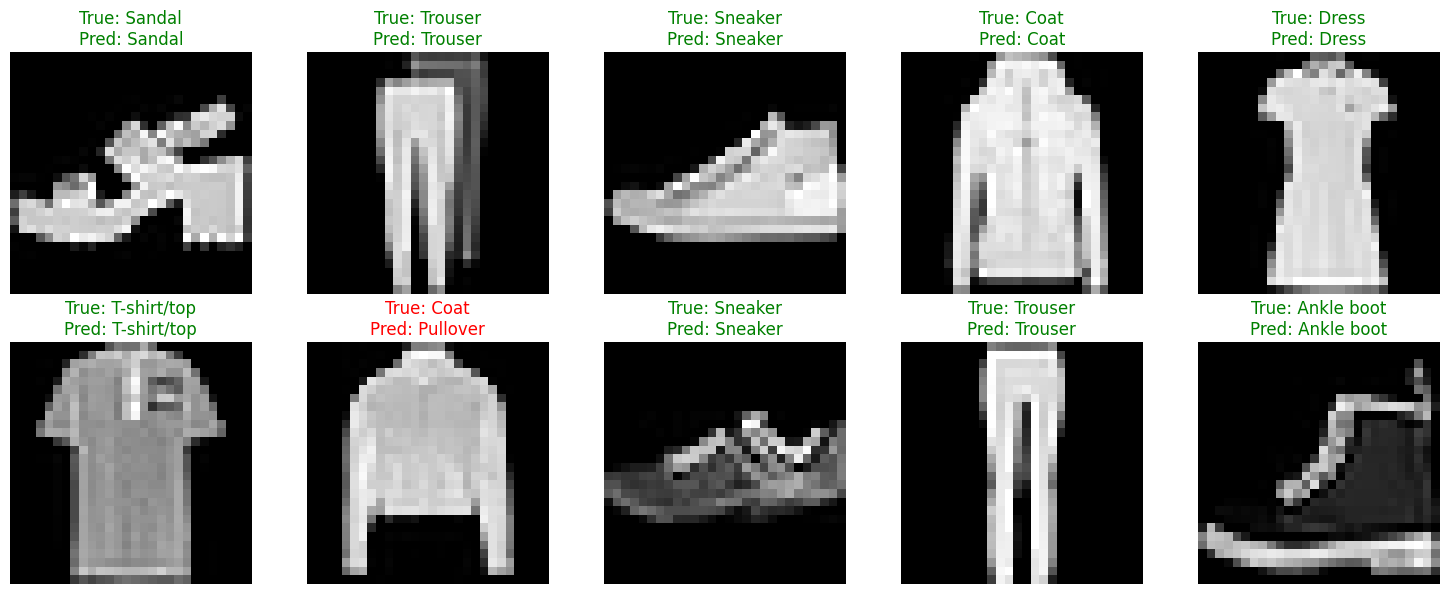

In [73]:
if __name__ == "__main__":
    model = main()
    test_model(model, torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    visualize_predictions(model, torch.device("cuda" if torch.cuda.is_available() else "cpu"))

In [ ]:
 https://wandb.ai/jaeminyu2356-korea-university-of-technology-and-education/fashion-mnist-resnet/runs/48i8t4ff